# 1D function models

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm.notebook import tqdm
import pandas as pd

from physics_mi.utils import set_all_seeds

In [3]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 3243091524  # this one is very interesting
# pleasingly_symmetric_seed = 95433229
set_all_seeds(seed)
print(seed)

1317031488


In [4]:
class config:
    POLY_ORDER = 20
    N_FUNCS = 10
    TRAIN_SIZE = 8000
    VALID_SIZE = 2000
    MODELS_PER_FUNC = 50
    MODEL_HIDDEN_DIM = 32

## Train source models

Not sure what to call these - so many models to refer to. These are the ones I'm going to classify.

In [24]:
from physics_mi.eval import *


def generate_polynomial(n=20):
    coeffs = np.random.rand(n) * 2 - 1
    return np.polynomial.Polynomial(coeffs)


def plot_funcs(funcs):
    _, axes = plt.subplots(2, 5, figsize=(15, 6))

    x = np.linspace(-1, 1, 100)
    for i, (ax, func) in enumerate(zip(axes.flatten(), funcs)):
        ax.plot(x, func(x))
        ax.set_title(f"Function {i}")


class PolynomialData:
    def __init__(self, func: np.polynomial.Polynomial, size: int) -> None:
        self.func = func
        self.size = size
        self.X = np.random.rand(size) * 2 - 1
        self.Y = self.func(self.X)
        self.torchify_data()

    def torchify_data(self):
        self.X = torch.as_tensor(self.X).float()[:, None]
        self.Y = torch.as_tensor(self.Y).float()[:, None]


def generate_polynomial_data(funcs, train_size, valid_size):
    return [
        {
            "train": PolynomialData(func, train_size),
            "valid": PolynomialData(func, valid_size),
        }
        for func in funcs
    ]


class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def get_model():
    return Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)


def train_model(train_data, valid_data):
    N = 100  # number of epochs

    model = Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)
    loss_func = nn.MSELoss()
    optimiser = Adam(model.parameters(), lr=1e-1)
    log = []

    for i in range(N):
        log_sample = {}

        # Training update
        model.train()
        model.zero_grad()
        Y_hat = model(train_data.X)
        loss = loss_func(Y_hat, train_data.Y)
        log_sample["train_loss"] = float(loss.detach())
        loss.backward()
        optimiser.step()

        # Validation set
        model.eval()
        Y_hat = model(valid_data.X)
        loss = loss_func(Y_hat, valid_data.Y)
        log_sample["valid_loss"] = float(loss.detach())

        log.append(log_sample)

    log = pd.DataFrame(log)

    return model, log


def get_preds(model, valid_data):
    model.eval()

    with torch.inference_mode():
        out = model(valid_data.X)

    y_preds = out.numpy()[:, 0]
    y_targs = valid_data.Y.numpy()[:, 0]

    return y_preds, y_targs


def plot_models(df, data, title=None):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    pdf = df.reset_index(drop=True)

    for ax, (i, row) in zip(axes.flatten(), pdf.iterrows()):
        model = get_model()
        model.load_state_dict(row["model"])
        valid_data = data[row["func"]]["valid"]

        y_preds, _ = get_preds(model, valid_data)

        sort_idxs = torch.argsort(valid_data.X[:, 0]).numpy()
        x = valid_data.X.numpy()[sort_idxs]
        y = valid_data.Y.numpy()[sort_idxs]
        y_preds_plot = y_preds[sort_idxs]

        ax.scatter(x, y_preds_plot, s=5, label="Predicted", alpha=0.5, color="grey")
        ax.plot(x, y, label="True", color="salmon")

        _ = ax.set_title(f"Function {i}")

    if title is not None:
        fig.suptitle(title)

In [ ]:
funcs = [generate_polynomial(config.POLY_ORDER) for _ in range(config.N_FUNCS)]
data = generate_polynomial_data(
    funcs, train_size=config.TRAIN_SIZE, valid_size=config.VALID_SIZE
)

models = []
for i, (func, func_data) in tqdm(enumerate(zip(funcs, data)), total=len(data)):
    for j in tqdm(range(config.MODELS_PER_FUNC), leave=False):
        model, log = train_model(func_data["train"], func_data["valid"])
        row = {}
        row["func"] = i
        row["repeat"] = j
        row["model"] = model.state_dict()
        row["valid_loss"] = log["valid_loss"].iloc[-1]
        models.append(row)
    print("\n")

mdf = pd.DataFrame(models)

In [9]:
mdf.loc[mdf["repeat"] == 0]

,func,repeat,model,valid_loss
0,0,0,"{'layers.0.linear.weight': [[tensor(-0.4690)],...",0.017636
50,1,0,"{'layers.0.linear.weight': [[tensor(0.1984)], ...",0.011233
100,2,0,"{'layers.0.linear.weight': [[tensor(-0.4963)],...",0.003006
150,3,0,"{'layers.0.linear.weight': [[tensor(0.4502)], ...",0.016263
200,4,0,"{'layers.0.linear.weight': [[tensor(-0.0933)],...",0.011472
250,5,0,"{'layers.0.linear.weight': [[tensor(-1.2115)],...",0.001826
300,6,0,"{'layers.0.linear.weight': [[tensor(-1.1693)],...",0.004676
350,7,0,"{'layers.0.linear.weight': [[tensor(0.4192)], ...",0.011238
400,8,0,"{'layers.0.linear.weight': [[tensor(-0.3536)],...",0.001466
450,9,0,"{'layers.0.linear.weight': [[tensor(-0.6625)],...",0.006284


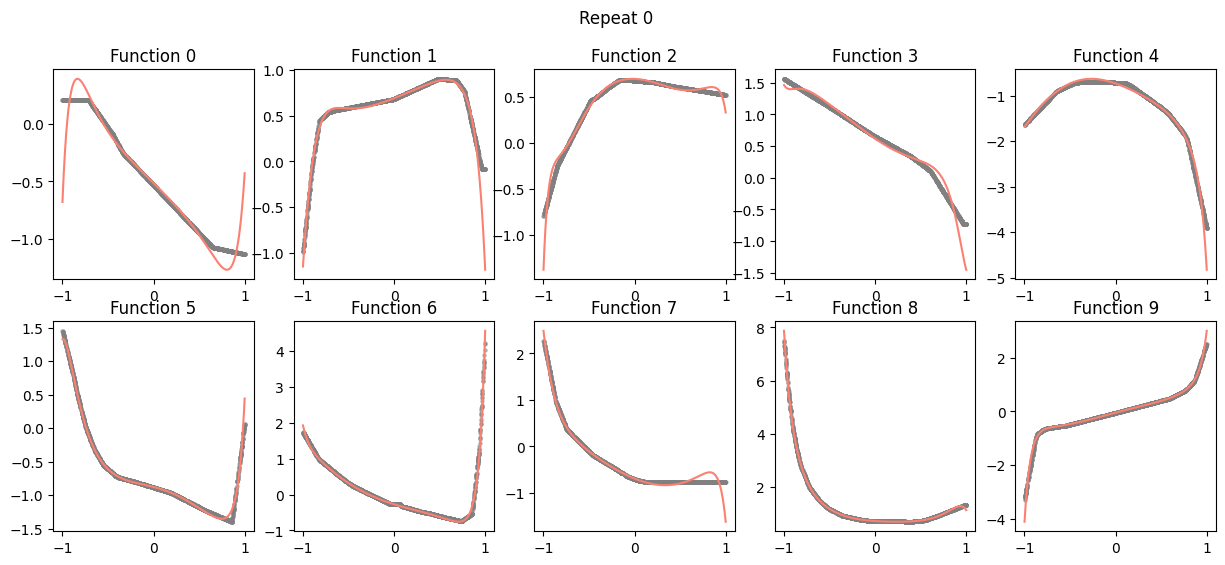

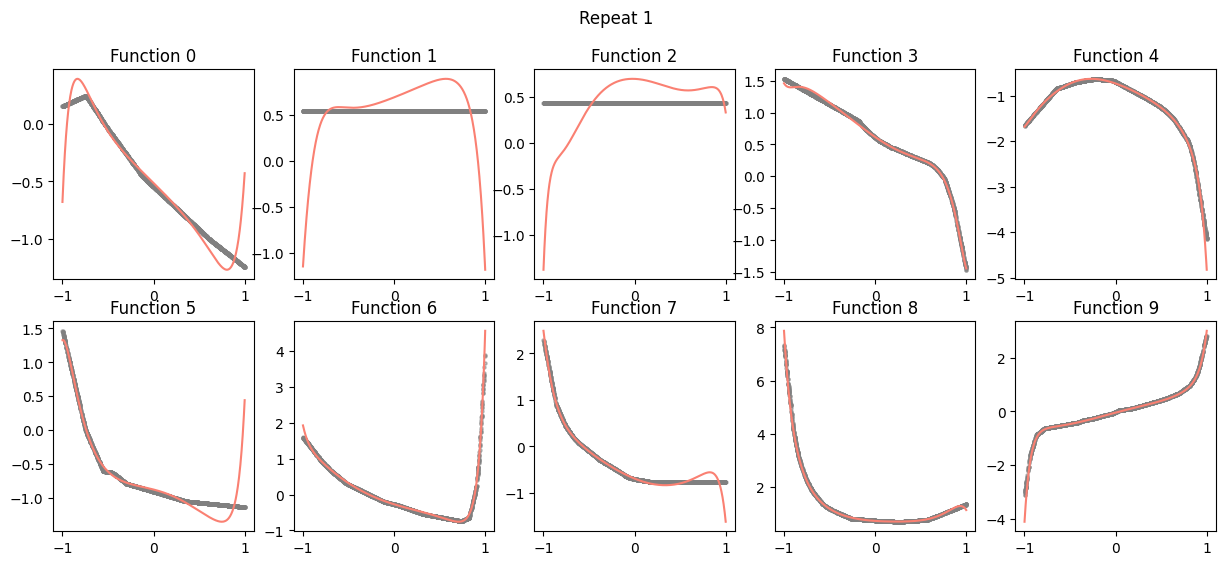

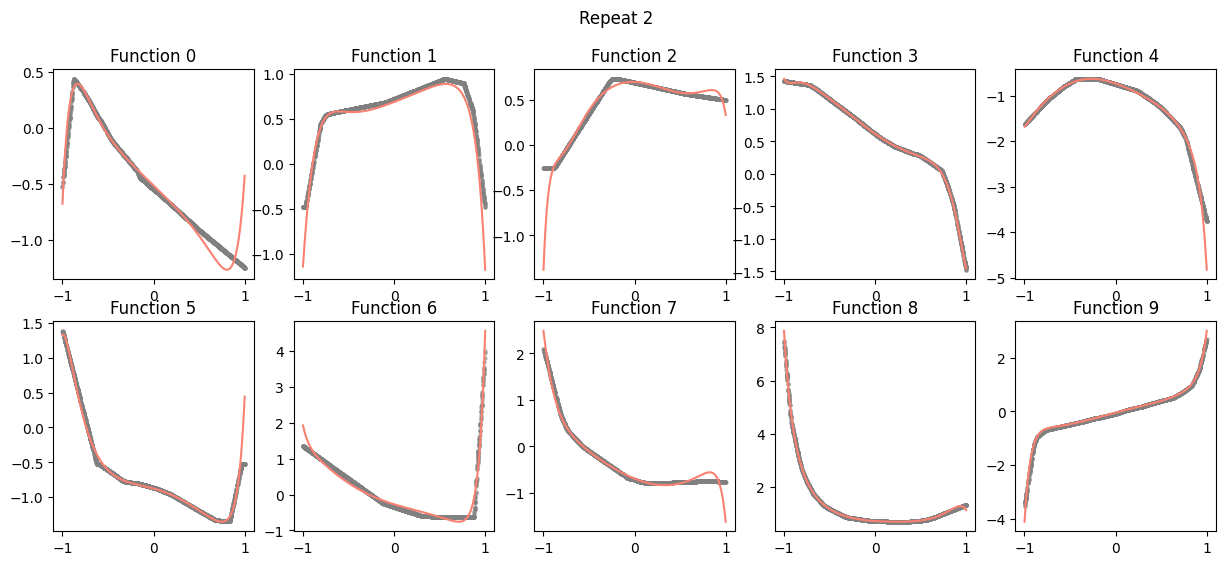

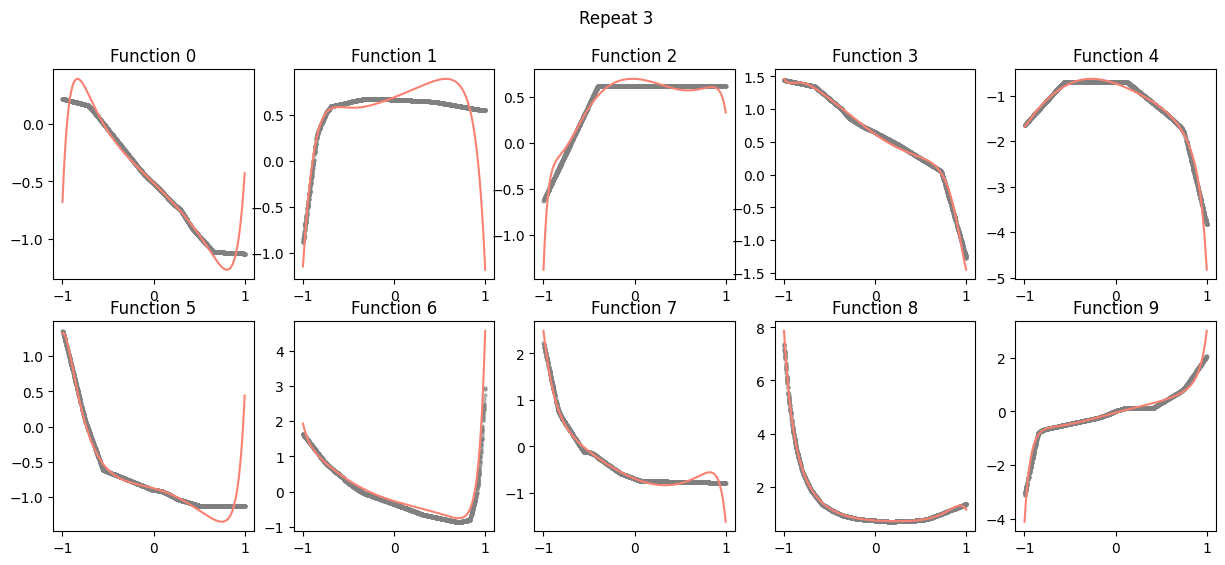

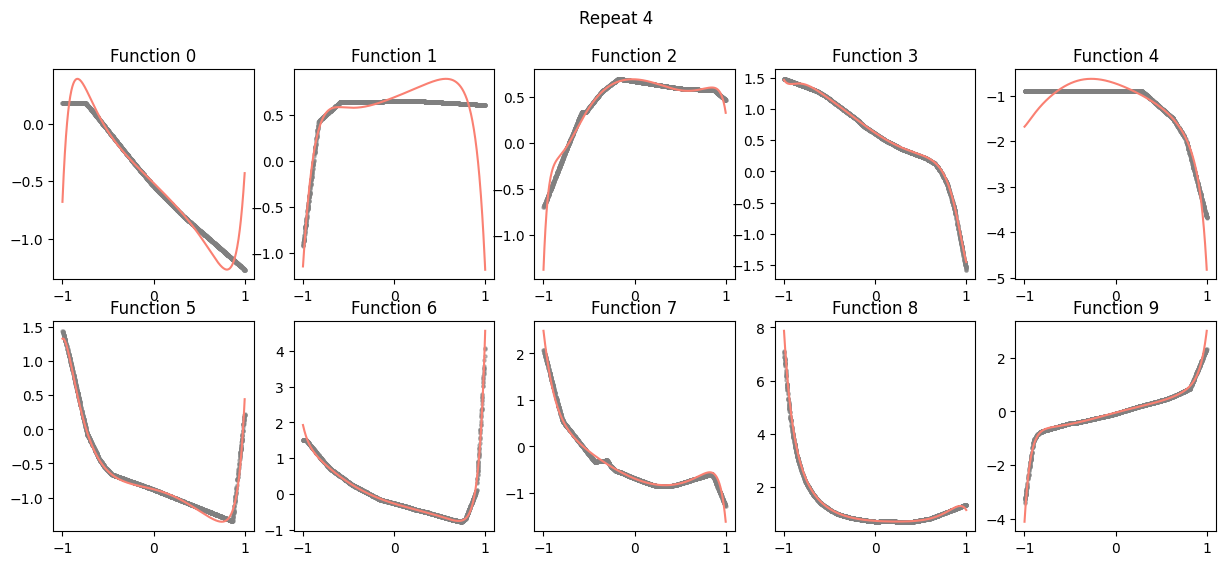

In [25]:
for i in range(5):
    plot_models(mdf.loc[mdf["repeat"] == i], data, title=f"Repeat {i}")

Sometimes there is some training collapse where the model predicts a static value as output, we probably want to avoid this if we're doing a cloze task - we want at least two different line sections per model... Could eliminate with some threshold on the loss but let's see how we go.

It's nice to see our line sections pretty clearly. We just have to hope that there is enough structure for our model to predict them well enough.

I'll need to be careful in the next section to make sure that $n_{samples} < n_{grads}$ because otherwise I can imagine the next model could simply learn to join up the dots linearly between the heavily sampled sections provided as opposed to understanding the underlying function.

## Train model embedder

Here's where it gets interesting.

So far we've trained 50 different networks to model each of our 10 1D polynomials. The plan now is to use these as training data for our auxiliary model i.e. the one that's going to be generating embeddings. 